In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from IPython.core.display import HTML
from matplotlib import animation
from matplotlib.colors import ListedColormap
import forward as AL
import backword as AL3
import csv
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("processed.csv")

In [3]:
with open('origin.csv') as f:
    df_origin = pd.read_csv(f)
with open('processed.csv') as f:
    df_processed = pd.read_csv(f)

In [4]:
p = df_origin[df_origin['wavenumber'] >= 1e-3]
p = p[p['wavenumber'] <= 2e-2]

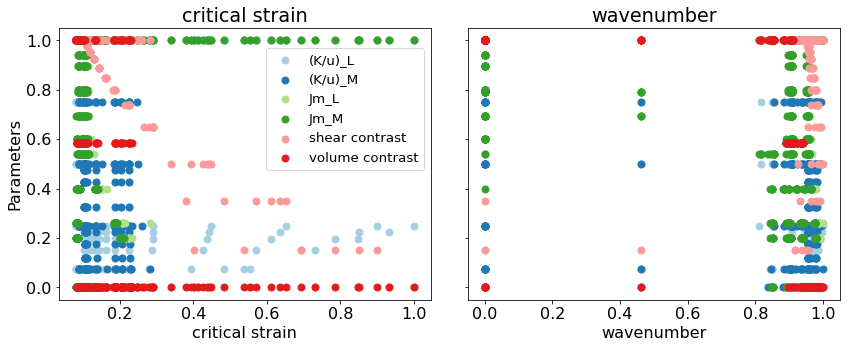

In [12]:
matplotlib.rcParams["font.size"] = 16
plot = plt.subplots(ncols = 2, figsize = (14,5), sharey = True)
subfigures = list(plot[1])
plt.subplots_adjust(wspace = 0.1)
df.plot.scatter(ax = subfigures[0], x ='critical strain', y = '(K/u)_L', s = 48, label = '(K/u)_L', c = '#a6cee3', title = 'critical strain')
df.plot.scatter(ax = subfigures[0], x ='critical strain', y = '(K/u)_M', s = 48, label = '(K/u)_M', c = '#1f78b4', title = 'critical strain')
df.plot.scatter(ax = subfigures[0], x ='critical strain', y = 'Jm_L', s = 48, label = 'Jm_L', c = '#b2df8a', title = 'critical strain')
df.plot.scatter(ax = subfigures[0], x ='critical strain', y = 'Jm_M', s = 48, label = 'Jm_M', c = '#33a02c', title = 'critical strain')
df.plot.scatter(ax = subfigures[0], x ='critical strain', y = 'u_L/u_M(Shear contrast)', s = 48, label = 'shear contrast', c = '#fb9a99', title = 'critical strain')
df.plot.scatter(ax = subfigures[0], x ='critical strain', y = 'volume contrast', s = 48, label = 'volume contrast', c = '#e31a1c', title = 'critical strain')
df.plot.scatter(ax = subfigures[1], x ='wavenumber', y = '(K/u)_L', s = 48, c = '#a6cee3', title = 'wavenumber')
df.plot.scatter(ax = subfigures[1], x ='wavenumber', y = '(K/u)_M', s = 48, c = '#1f78b4', title = 'wavenumber')
df.plot.scatter(ax = subfigures[1], x ='wavenumber', y = 'Jm_L', s = 48, c = '#b2df8a', title = 'wavenumber')
df.plot.scatter(ax = subfigures[1], x ='wavenumber', y = 'Jm_M', s = 48, c = '#33a02c', title = 'wavenumber')
df.plot.scatter(ax = subfigures[1], x ='wavenumber', y = 'u_L/u_M(Shear contrast)', s = 48, c = '#fb9a99', title = 'wavenumber')
df.plot.scatter(ax = subfigures[1], x ='wavenumber', y = 'volume contrast', s = 48, c = '#e31a1c', title = 'wavenumber')
subfigures[0].set_ylabel('Parameters')
subfigures[0].legend(loc='best',bbox_to_anchor=(0.7, 0.65, 0.3, 0.3), fontsize = 'small')

In [6]:
subfigures[0].get_figure().savefig("data_overview.png", bbox_inches="tight")

In [7]:
#based on Tyler's code
xcols = list(df.columns[:6])
train, test = train_test_split(df)

In [8]:
pipe = Pipeline([
    ("std", StandardScaler()),
    ("poly", PolynomialFeatures(3)),
    ("lr", LinearRegression()),
])

In [9]:
p = []
t = []
poly = []
for i in range(1,8):
    pipe = Pipeline([
        ("std", StandardScaler()),
        ("poly", PolynomialFeatures(i)),
        ("lr", LinearRegression()),
    ])

    pipe.fit(train[xcols], train["wavenumber"])
    p.append(explained_variance_score(test["wavenumber"], pipe.predict(test[xcols])))
    t.append(explained_variance_score(train["wavenumber"], pipe.predict(train[xcols])))
    poly.append(i)
    res = (
        explained_variance_score(train["wavenumber"], pipe.predict(train[xcols])),
        explained_variance_score(test["wavenumber"], pipe.predict(test[xcols])),
    )
    

In [10]:
p2 = []
t2 = []

for i in range(1,8):
    pipe2 = Pipeline([
        ("std", StandardScaler()),
        ("poly", PolynomialFeatures(i)),
        ("lr", LinearRegression()),
    ])

    pipe2.fit(train[xcols], train["critical strain"])
    p2.append(explained_variance_score(test["critical strain"], pipe2.predict(test[xcols])))
    t2.append(explained_variance_score(train["critical strain"], pipe2.predict(train[xcols])))

    res = (
        explained_variance_score(train["critical strain"], pipe2.predict(train[xcols])),
        explained_variance_score(test["critical strain"], pipe2.predict(test[xcols])),
    )
    

In [11]:
d = {"poly":poly, "wavenumber train":t, "wavenumber predict":p, "critical strain train": t2, "critical strain predict": p2}

In [12]:
res_data = pd.DataFrame(d)

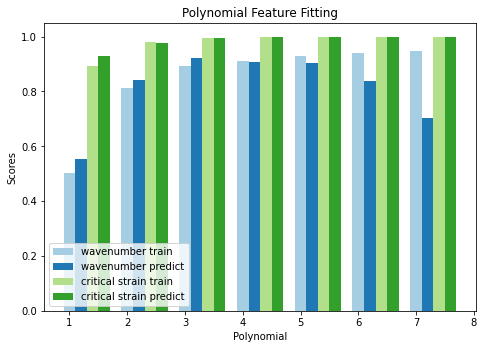

In [13]:

data = [t,p, t2, p2]
X = np.arange(1,7.8)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Scores')
ax.set_xlabel('Polynomial')
ax.set_title('Polynomial Feature Fitting')
ax.bar(X + 0.00, data[0], color = '#a6cee3', width = 0.2, label = "wavenumber train")
ax.bar(X + 0.2, data[1], color = '#1f78b4', width = 0.2, label = "wavenumber predict")
ax.bar(X + 0.4, data[2], color = '#b2df8a', width = 0.2, label = "critical strain train")
ax.bar(X + 0.6, data[3], color = '#33a02c', width = 0.2, label = "critical strain predict")
ax.legend(loc='lower left')
plt.show()

In [17]:
ax.get_figure().savefig("poly_fit.svg", bbox_inches="tight")

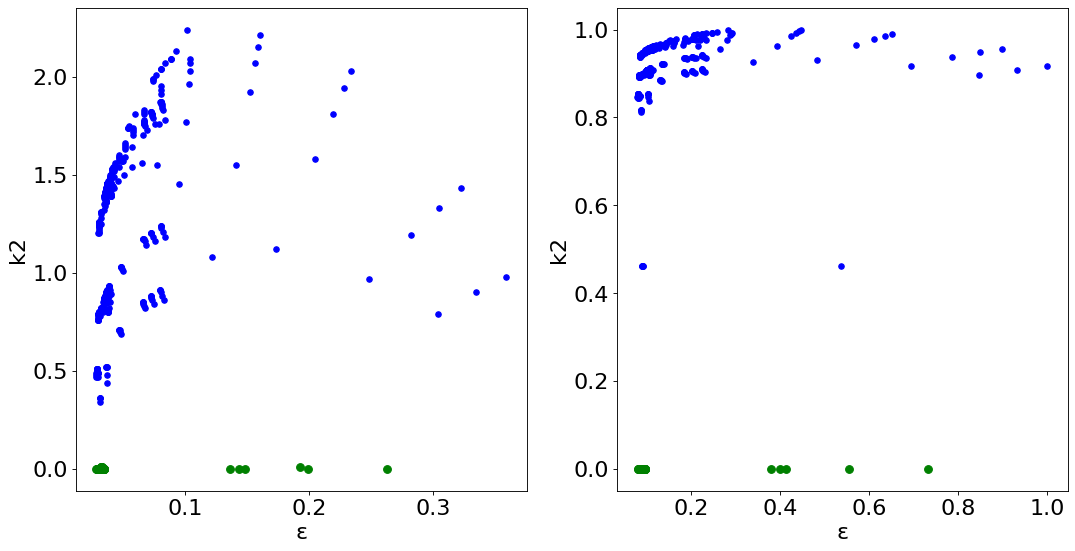

In [20]:
x = AL.results_visualization()

In [18]:
x.savefig("forward.svg", bbox_inches="tight")

In [28]:
# train net with optimization method chose
df_origin_macro = df_origin[df_origin['wavenumber'] <= 2e-2]
df_origin_micro = df_origin[df_origin['wavenumber'] > 2e-2]
df_processed_macro = df_processed[df_processed['wavenumber'] == 0]
df_processed_micro = df_processed[df_processed['wavenumber'] != 0]
df_train_macro, df_test_macro = train_test_split(df_processed_macro, train_size = 0.7)
df_train_micro, df_test_micro = train_test_split(df_processed_micro, train_size = 0.7)
df_test = pd.concat( [df_test_macro, df_test_micro], axis=0)
net = AL.ANN_L2(n_feature = dim_input, n_hidden1 = n_hidden_layer1, n_hidden2 = n_hidden_layer2, n_output = dim_output)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
# error computation method
loss_func = torch.nn.MSELoss()
# divide dataset into train set and test set
train_macro, test_macro = train_test_split(df_processed_macro, train_size = 0.7)
train_micro, test_micro = train_test_split(df_processed_micro, train_size = 0.7)
train = pd.concat( [train_macro, train_micro], axis=0)
test = pd.concat( [test_macro, test_micro], axis=0)
train_input_tensor = torch.tensor(train.iloc[:,0:6].values)
train_output_tensor = torch.tensor(train.iloc[:,6:].values)
test_input_tensor = torch.tensor(test.iloc[:,0:6].values)
test_output_tensor = torch.tensor(test.iloc[:,6:].values)

fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.set_xlabel('epoch', fontsize=20)
ax1.set_ylabel('error', fontsize=20)
plt.ylim(0,1)
plt.tick_params(labelsize=20)

def frame_maker(train):
    global error
    error = pd.DataFrame(columns=['epoch','error'])
    # start training and :ilustrate the 
    for i in range(n_train):

        # input data to predict
        prediction = net(train_input_tensor.float())
    
        # error between expected data and predicted data, pay attention on consequence
        # first is predicted, second is real value
        loss = loss_func(prediction, train_output_tensor.float())

        # start optimize
        # set gradient as 0 before each optimization
        optimizer.zero_grad()
    
        # error pachpropogation
        loss.backward()
    
        # optimize parameters based on minimum loss
        optimizer.step()
        error = error.append(pd.DataFrame({'epoch':[i],'error':[loss.data.numpy()]}))

        if (i//10 == 0 or i//10 == 5) and i > 5:

            x = np.array(error['epoch'],dtype='float')
            y = np.array(error['error'],dtype='float')
            ax1.plot(x,y,'r')
            ax1.set_ylim(0.001,0.4)



ani = animation.FuncAnimation(fig1, frame_maker, frames=list(range(30)))
html = ani.to_html5_video()
plt.close(fig1)
HTML(html)

ANN_L2(
  (hidden_layer1): Linear(in_features=2, out_features=20, bias=True)
  (hidden_layer2): Linear(in_features=20, out_features=20, bias=True)
  (predict_layer): Linear(in_features=20, out_features=6, bias=True)
)
The main square error of trained net in test set (expected and predicted): 104.55418


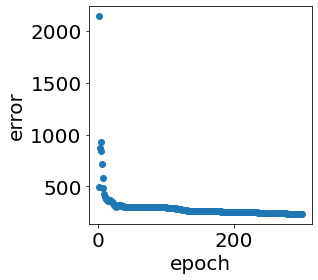

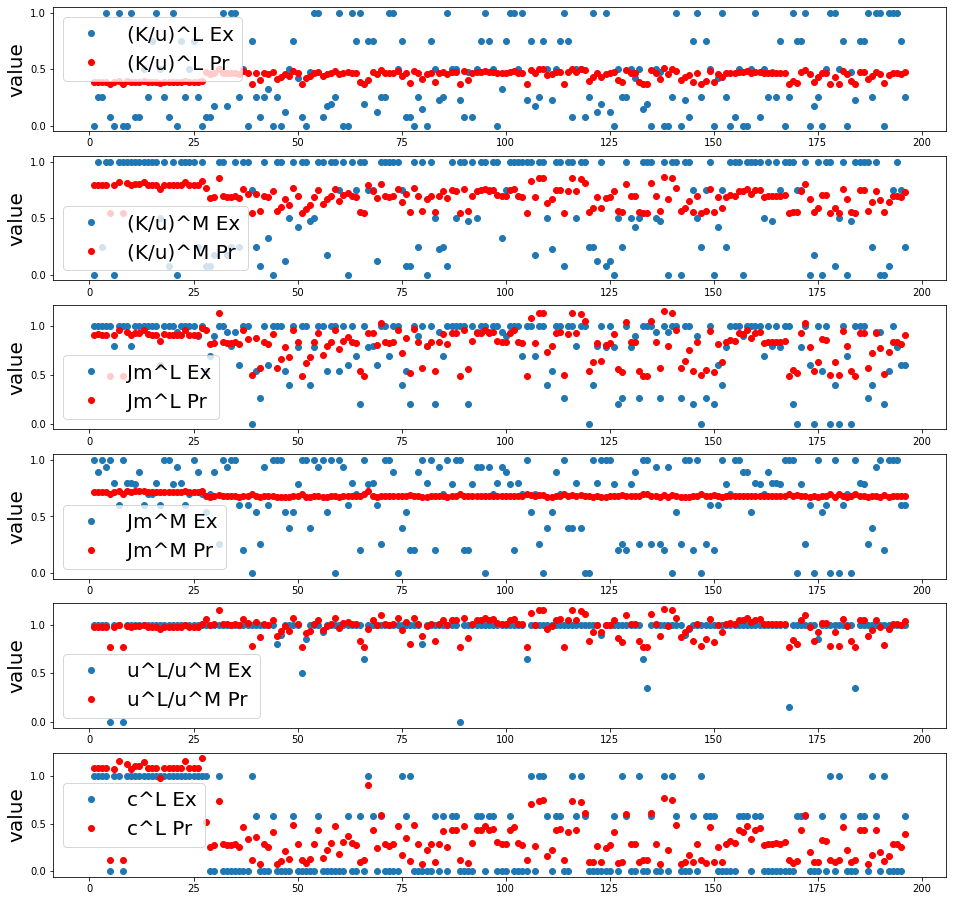

In [14]:
n_train = 300
n_hidden_layer = [20, 20]
learning_rate = 0.1

fig = AL3.ANN_Linear_train_fig(n_train, n_hidden_layer, learning_rate, backward = True)

In [30]:
fig.savefig("backward.svg", bbox_inches="tight")

In [15]:
errs = []
nt = []
for i in range(300):
    n_train = i
    dim_input = 6
    dim_output = 2
    n_hidden_layer1 = 10
    n_hidden_layer2 = 10
    learning_rate = 0.1
    err = AL.ANN_L2_forward_error(n_train, dim_input, dim_output, n_hidden_layer1, n_hidden_layer2, learning_rate)
    errs.append(err)
    nt.append(i)
d = {"n_train":nt, "errors":errs}
err_data = pd.DataFrame(d)


KeyboardInterrupt: 

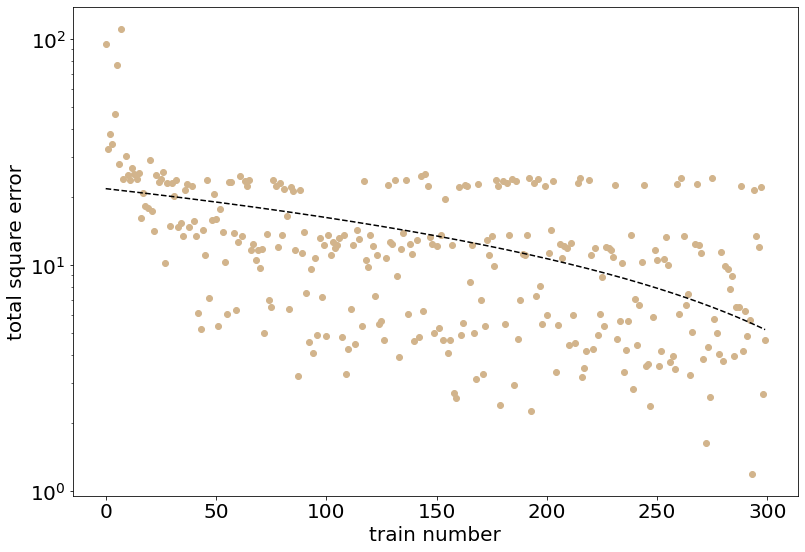

In [13]:
#https://stackoverflow.com/questions/41635448/how-can-i-draw-scatter-trend-line-on-matplot-python-pandas/41635626
x = err_data.iloc[:,0]
y = err_data.iloc[:,1]
fig, ax = plt.subplots(figsize=(13,9))
#err_data.plot.scatter(x='n_train', y='errors', c ='tan', ax = subfigures[0])
ax.scatter(x,y,c='tan')
ax.set_yscale('log')
ax.set_ylabel('total square error', fontsize=20)
ax.set_xlabel('train number', fontsize=20)
plt.tick_params(labelsize=20)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"r--", c='black')


In [14]:
ax.get_figure().savefig("error_dis.svg", bbox_inches="tight")

In [ ]:
dim_input = 6
dim_output = 2
learning_rate = 0.1
c10 = [
    AL.ANN_L1_forward_error(n_train, dim_input, dim_output, 10, learning_rate),
    AL.ANN_L2_forward_error(n_train, dim_input, dim_output, 10, 10, learning_rate),
    AL.ANN_L3_forward_error(n_train, dim_input, dim_output, 10, 10, 10, learning_rate)
]
c20 = [
    AL.ANN_L1_forward_error(n_train, dim_input, dim_output, 20, learning_rate),
    AL.ANN_L2_forward_error(n_train, dim_input, dim_output, 20, 20, learning_rate),
    AL.ANN_L3_forward_error(n_train, dim_input, dim_output, 20, 20, 20, learning_rate)
]
c30 = [AL.ANN_L1_forward_error(n_train, dim_input, dim_output, 30, learning_rate),
    AL.ANN_L2_forward_error(n_train, dim_input, dim_output, 30, 30, learning_rate),
    AL.ANN_L3_forward_error(n_train, dim_input, dim_output, 30, 30, 30, learning_rate)]
c100 = [AL.ANN_L1_forward_error(n_train, dim_input, dim_output, 100, learning_rate),
    AL.ANN_L2_forward_error(n_train, dim_input, dim_output, 100, 100, learning_rate),
    AL.ANN_L3_forward_error(n_train, dim_input, dim_output, 100, 100, 100, learning_rate)]
hidden = [1,2,3]
d = {"n hidden layer":hidden, "10 cells":c10, "20 cells":c20, "30 cells":c30, "100 cells":c100}
err_data = pd.DataFrame(d)

    

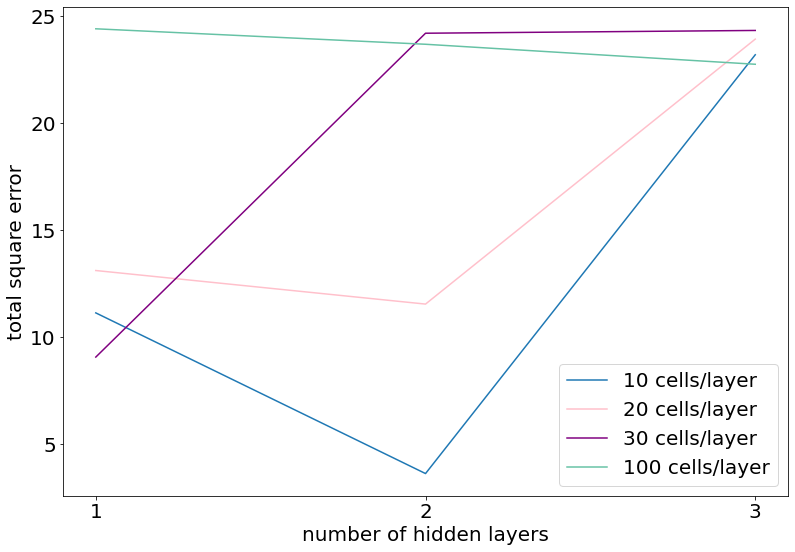

In [42]:
fig, ax = plt.subplots(figsize=(13,9))
err_data.plot(kind='line',x='n hidden layer',y='10 cells', color='#1f78b4', ax=ax, label = '10 cells/layer')
err_data.plot(kind='line',x='n hidden layer',y='20 cells', color='pink', ax=ax, label = '20 cells/layer')
err_data.plot(kind='line',x='n hidden layer',y='30 cells', color='purple', ax=ax, label = '30 cells/layer')
err_data.plot(kind='line',x='n hidden layer',y='100 cells', color='#66c2a5', ax=ax, label = '100 cells/layer')
ax.set_ylabel('total square error', fontsize=20)
ax.set_xlabel('number of hidden layers', fontsize=20)
ax.legend(loc='best', fontsize = 20)
tick_marks = [1,2,3]
ax.set_xticks(tick_marks)
plt.tick_params(labelsize=20)

In [43]:
ax.get_figure().savefig("hidden_err.svg", bbox_inches="tight")

In [ ]:
hidden = []
layer1 = []
layer2 = []
layer3 = []
for i in range(10,510,10):
    dim_input = 6
    n_train = 100
    dim_output = 2
    learning_rate = 0.1
    err2 = AL.ANN_L2_forward_error(n_train, dim_input, dim_output, i, i, learning_rate)
    err1 = AL.ANN_L1_forward_error(n_train, dim_input, dim_output, i, learning_rate)
    err3 = AL.ANN_L3_forward_error(n_train, dim_input, dim_output, i, i, i, learning_rate)
    layer1.append(err1)
    layer2.append(err2)
    layer3.append(err3)
    hidden.append(i)

    
d = {"n hidden layer":hidden, "1 hidden":layer1, "2 hidden":layer2, "3 hidden":layer3}
err_data = pd.DataFrame(d)


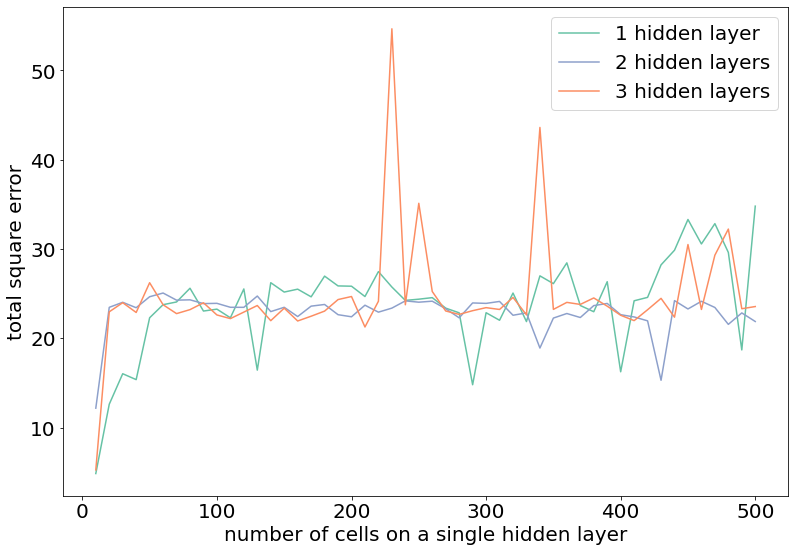

In [6]:
fig, ax = plt.subplots(figsize=(13,9))
err_data.plot(kind='line',x='n hidden layer',y='1 hidden', color='#66c2a5', ax=ax, label = '1 hidden layer')
err_data.plot(kind='line',x='n hidden layer',y='2 hidden', color='#8da0cb', ax=ax, label = '2 hidden layers')
err_data.plot(kind='line',x='n hidden layer',y='3 hidden', color='#fc8d62', ax=ax, label = '3 hidden layers')
ax.set_ylabel('total square error', fontsize=20)
ax.set_xlabel('number of cells on a single hidden layer', fontsize=20)
ax.legend(loc='best', fontsize = 20)
plt.tick_params(labelsize=20)

In [7]:
ax.get_figure().savefig("cell_and_hidden.svg", bbox_inches="tight")